In [1]:
import sys
sys.path.append("../../")
from pathlib import Path

import tqdm
import numpy as np
import torch

from frag.mol.mols import Mol, MolInputRDKIT
from frag.graph.molgraph import MolGraph, MolGraphDataset, MolGraphDataSetGenerator
from frag.fragmentation.fragmenters import BondFragmenter, AngleFragmenter
from frag.labeling.labelers import BondLabeler, AngleLabeler
from frag.featurization.atom_featurizers import RDKITFingerprint


from frag.graph.message_passing import MessagePassingBonded
from frag.graph.readout import ReadoutJanossyLinear

/net/cci/cschlick/miniconda3/envs/restraintsML/envs/restraintsML6/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from frag.mol.mols import Mol

In [5]:
mol = Mol(mol_input)

In [6]:
mol.write_geo("../../tmp/debug.cif")

In [7]:
# debug
mol = Mol.from_file_geocif('/dev/shm/cschlick/CODoutput/cif/7/70/68/7706849_000_geo.cif')

# Predict bonds via gnn

In [18]:
from frag.utils.plotting import plot_geom_eval

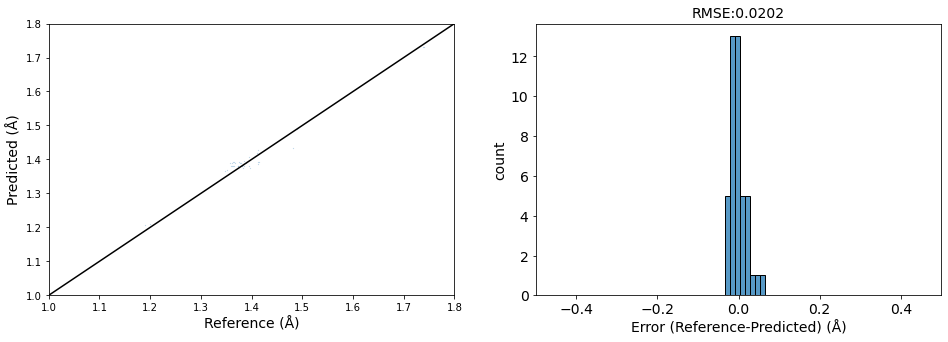

In [20]:
plot_geom_eval(ref_labels,pred_labels,mode="bond")

# Predict angles via gnn

In [21]:
label_name = "angle_value"
file_pkl = "../../pretrained/gnn_angles_dsgen.pkl"

In [22]:
ds_gen = MolGraphDataSetGenerator.from_file_pickle(file_pkl)

In [23]:
ds = ds_gen(mol,disable_progress=True)

In [24]:
model = ds_gen.pretrained_models["predictor"]

In [25]:
pred_graph = model(ds.fragment_graph)

In [26]:
ref_labels = to_np(pred_graph.nodes["fragment"].data[label_name]).flatten()

In [27]:
assert np.all(np.isclose(ref_labels,mol.angles.angle_value)), "Graph bonds and mol object bonds not matching"

In [28]:
pred_labels = to_np(pred_graph.nodes["fragment"].data[label_name+"_pred"]).flatten()

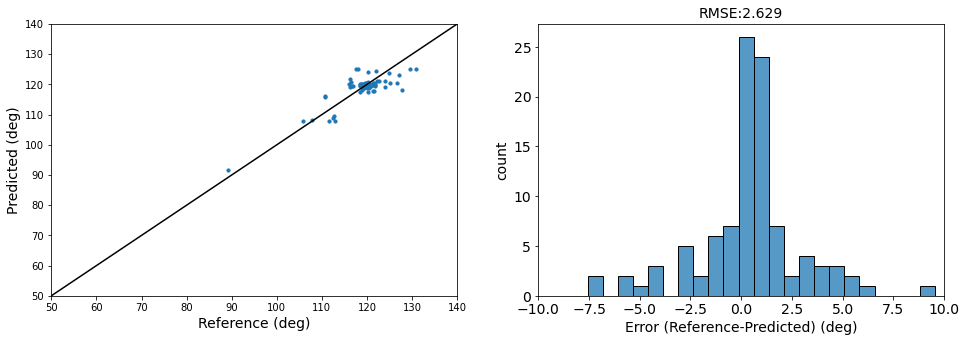

In [29]:
plot_geom_eval(ref_labels,pred_labels,mode="angle",s=10)

In [33]:
# set predicted
for pred,angle in zip(pred_labels,mol.angles):
  angle.angle_ideal = pred